In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functions, losses
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7fbedecdcc40>, 5)

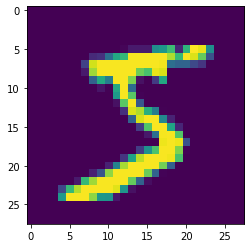

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

# In Pytorch

In [1]:
# Pytorch model and training tensors

class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(28*28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x) # first layer
        x = F.relu(x)  # activation function
        x = self.l2(x) # secound layer: down to 10 outputs
        #x = self.sm(x) # softmax
        return x

dummy_tensor = torch.Tensor([X_train[0].reshape(28*28)])
print("Does dummy_tensor require a gradient ?", dummy_tensor.requires_grad)
dummy_output = TorchNet()(dummy_tensor)
print("Does dummy_output require a gradient ?", dummy_output.requires_grad)


NameError: name 'nn' is not defined

In [10]:
# Testing two different losses

nn_NLLLoss = nn.NLLLoss(reduction="mean")
nn_MSELoss = nn.MSELoss(reduction="mean")
nn_CrossEntropyLoss = nn.CrossEntropyLoss(reduction="mean")

def NLLLoss(Y_pred, Y):
    """
    works well (with a final LogSoftmax layer !)
    """
    loss = nn_NLLLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

def MSELoss(Y_pred, Y):
    """
    doesn't work at all
    """
    Y_one_hot = torch.zeros(Y.shape[0], 10)
    slice = [(i, y) for i, y in enumerate(Y)] if Y.shape[0] > 1 else (0,Y[0])
    Y_one_hot[slice] = 1.0

    loss = nn_MSELoss(Y_pred, Y_one_hot)

    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()
    
    return loss, accuracy

def CrossEntropyLoss(Y_pred, Y):
    """
    works well 
    """
    loss = nn_CrossEntropyLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

loss 0.93 accuracy 0.77:   3%|▎         | 26/1000 [00:00<00:03, 256.89it/s]

Y_pred: tensor([ 14.,   4.,  21., -11., -12.,  17.,  22., -12.,   6.,   4.],
       grad_fn=<RoundBackward>)
Y: tensor(9)
Y_pred after argmax: tensor(6)
loss: tensor(31.8167, grad_fn=<NllLossBackward>)


loss 0.12 accuracy 0.95: 100%|██████████| 1000/1000 [00:03<00:00, 304.84it/s]


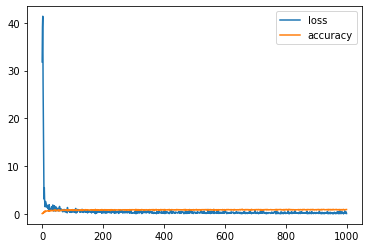

In [12]:
# Pytorch Training

model = TorchNet()

# Loss function defined above
loss_fn = CrossEntropyLoss

# Stocastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# Training paramaters
epochs = 1000
batch_size = 64

losses, accuracies = [], []

# Training loop
for i in (t := trange(epochs)):
    # Get random slicing the size of the batch
    sample = np.random.randint(0, X_train.shape[0], size=(batch_size))

    # Define X and Y (flatten X so the image is one single dimention)
    # Conversion to float is important so the Linear layers accept X as a input
    X = torch.tensor(X_train[sample].reshape(-1, 28*28), dtype=torch.float)
    Y = torch.tensor(Y_train[sample], dtype=torch.long)

    Y_pred = model(X)

    # This prints shows the form of Y_pred, it is clear argmax needs to be applied
    # to compare Y_pred with Y
    if i == 0:
        print("Y_pred:", Y_pred[0].round())
        print("Y:", Y[0])
        print("Y_pred after argmax:", torch.argmax(Y_pred, dim=1)[0])
    
    loss, accuracy = loss_fn(Y_pred, Y)

    if i == 0:
        print("loss:", loss)

    # Backpropagation
    loss.backward()

    # Updating weights
    optimizer.step()

    # Reset weights for next epoch
    model.zero_grad()

    loss = loss.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.plot(losses, label="loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()


# In Edunets

max value of first layer: 0.049999062
max value of input: 255.0
max value after first layer: 763.12256


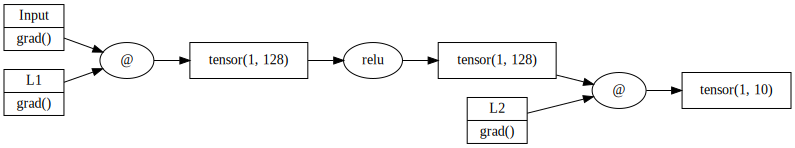

In [14]:
class EduNet1:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128, high=0.05, requires_grad=True, label="L1")
        self.l2 = Tensor.uniform(128, 10, high=0.05, requires_grad=True, label="L2")

    def __call__(self, x):
        x = x @ self.l1
        print("max value after first layer:", np.max(x.data))
        x = x.relu()
        x = x @ self.l2
        return x

model = EduNet1()
dummy_tensor = Tensor([X_train[0].reshape(28*28)], requires_grad=True, label="Input")
dummy_output = model(dummy_tensor)
dummy_output.graph

In [15]:
def argmax(t, **kargs): 
    return Tensor(np.argmax(t.data, **kargs))

# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=0.001):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            t.assign(t.data - t.grad * self.lr)

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [16]:
from edunets.losses import CrossEntropyLoss

model = EduNet1()

loss_fn = CrossEntropyLoss(reduction="mean")
optim = SGD([model.l1, model.l2], lr=0.001)
batch_size = 64
epochs = 1000
losses, accuracies = [], []

for i in (t := trange(epochs)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)), requires_grad=True)
    Y = Tensor(Y_train[samp])

    out = model(X)
    
    cat = argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()

    loss = loss_fn.forward(out, Y)
    
    optim.zero_grad()
    
    loss.backward()
    
    optim.step()
    
    losses.append(loss.data)
    
    accuracies.append(accuracy.data)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss.data, accuracy.data))

loss.graph


  0%|          | 0/1000 [00:00<?, ?it/s]/home/goncalo/edunets/edunets/functions.py:19: RuntimeWarning: overflow encountered in exp
  return np.exp(self.a.data)
/home/goncalo/anaconda3/envs/pi_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
loss -2132.52 accuracy 0.14:   0%|          | 0/1000 [00:00<?, ?it/s]/home/goncalo/edunets/edunets/functions.py:115: RuntimeWarning: overflow encountered in matmul
  return self.a.data @ self.b.data
/home/goncalo/edunets/edunets/functions.py:115: RuntimeWarning: invalid value encountered in matmul
  return self.a.data @ self.b.data
/home/goncalo/edunets/edunets/functions.py:118: RuntimeWarning: invalid value encountered in matmul
  self.a._update_grad(self.out.grad @ self.b.data.T)
loss 2.30 accuracy 0.03:   1%|          | 7/1000 [00:00<00:16, 61.18it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 1482.9926
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer

loss 2.30 accuracy 0.12:   2%|▏         | 22/1000 [00:00<00:14, 67.94it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.12:   4%|▍         | 38/1000 [00:00<00:14, 67.90it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.09:   4%|▍         | 45/1000 [00:00<00:15, 60.55it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input:

loss 2.30 accuracy 0.12:   6%|▌         | 59/1000 [00:01<00:15, 58.95it/s]

 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first l

loss 2.30 accuracy 0.12:   7%|▋         | 74/1000 [00:01<00:15, 60.81it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.05:   8%|▊         | 81/1000 [00:01<00:16, 55.71it/s]

0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input

loss 2.30 accuracy 0.11:   9%|▉         | 94/1000 [00:01<00:16, 55.34it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.09:  10%|█         | 100/1000 [00:01<00:19, 47.03it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.12:  11%|█         | 111/1000 [00:02<00:20, 44.27it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.05:  12%|█▏        | 124/1000 [00:02<00:17, 49.09it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.06:  14%|█▍        | 138/1000 [00:02<00:14, 58.20it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.06:  14%|█▍        | 145/1000 [00:02<00:15, 54.12it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.05:  16%|█▌        | 158/1000 [00:02<00:15, 54.93it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.11:  17%|█▋        | 173/1000 [00:03<00:13, 60.89it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.05:  19%|█▉        | 188/1000 [00:03<00:12, 64.35it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.16:  20%|██        | 202/1000 [00:03<00:12, 65.42it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.11:  21%|██        | 209/1000 [00:03<00:13, 57.73it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.09:  22%|██▏       | 221/1000 [00:03<00:15, 50.76it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.08:  23%|██▎       | 234/1000 [00:04<00:13, 56.35it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.14:  24%|██▍       | 240/1000 [00:04<00:14, 52.45it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.06:  26%|██▌       | 255/1000 [00:04<00:12, 57.60it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.14:  27%|██▋       | 267/1000 [00:04<00:14, 51.24it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  28%|██▊       | 282/1000 [00:05<00:12, 59.13it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.14:  29%|██▉       | 289/1000 [00:05<00:12, 56.24it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.06:  30%|███       | 301/1000 [00:05<00:13, 51.48it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.06:  31%|███▏      | 314/1000 [00:05<00:12, 53.55it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.05:  32%|███▏      | 320/1000 [00:05<00:13, 51.36it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  34%|███▎      | 336/1000 [00:06<00:11, 57.04it/s]

 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of inpu

loss 2.30 accuracy 0.12:  35%|███▍      | 349/1000 [00:06<00:11, 58.93it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.11:  36%|███▋      | 363/1000 [00:06<00:10, 58.14it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.08:  37%|███▋      | 370/1000 [00:06<00:10, 57.97it/s]

max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0

loss 2.30 accuracy 0.09:  38%|███▊      | 385/1000 [00:06<00:09, 62.88it/s]

 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of inpu

loss 2.30 accuracy 0.17:  40%|███▉      | 399/1000 [00:07<00:10, 58.20it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.06:  40%|████      | 405/1000 [00:07<00:10, 56.46it/s]

 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first l

loss 2.30 accuracy 0.22:  42%|████▏     | 419/1000 [00:07<00:12, 48.28it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.12:  42%|████▎     | 425/1000 [00:07<00:11, 48.33it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.06:  44%|████▍     | 441/1000 [00:07<00:10, 51.50it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.06:  46%|████▌     | 456/1000 [00:08<00:09, 57.99it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.09:  46%|████▋     | 463/1000 [00:08<00:08, 60.46it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.09:  48%|████▊     | 478/1000 [00:08<00:08, 60.37it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  50%|████▉     | 495/1000 [00:08<00:07, 68.91it/s]

 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of inpu

loss 2.30 accuracy 0.20:  52%|█████▏    | 515/1000 [00:09<00:06, 72.82it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.14:  52%|█████▏    | 523/1000 [00:09<00:06, 69.17it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  53%|█████▎    | 531/1000 [00:09<00:08, 58.03it/s]

 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


loss 2.30 accuracy 0.05:  55%|█████▍    | 545/1000 [00:09<00:07, 57.15it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.11:  56%|█████▌    | 561/1000 [00:09<00:06, 65.95it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.17:  58%|█████▊    | 578/1000 [00:10<00:05, 72.10it/s]

 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer:

loss 2.30 accuracy 0.11:  60%|█████▉    | 596/1000 [00:10<00:05, 78.14it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  61%|██████▏   | 614/1000 [00:10<00:04, 80.96it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.11:  62%|██████▏   | 623/1000 [00:10<00:04, 78.65it/s]

max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.04

loss 2.30 accuracy 0.08:  63%|██████▎   | 633/1000 [00:10<00:06, 59.14it/s]


max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0
max value of first layer: 0.049999706
max value of input: 255.0
max value after first layer: 0.0


KeyboardInterrupt: 

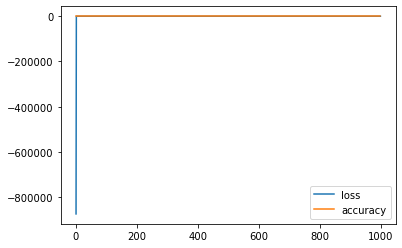

In [6]:
plt.plot(losses, label="loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()